# Exploring a Amazon data network in Memgraph

Through this short tutorial, you will learn how to install Memgraph, connect to it from a Jupyter Notebook and perform data analysis on Amazon data set using **graph neural network** called **Temporal graph networks**.
## 1. Prerequisites

For this tutorial, you will need to install:

- [Jupyter](https://jupyter.org/install)
- [Docker](https://docs.docker.com/get-docker/)
- [GQLAlchemy](https://pypi.org/project/gqlalchemy/)

Docker is used because Memgraph is a native Linux application and cannot be installed on Windows and macOS.

## 2. Installation using Docker

After you install Docker, you can set up Memgraph by running:

```
docker run -it -p 7687:7687 -p 3000:3000 -p 7444:7444 memgraph/memgraph-platform
```

This command will start the download and after it finishes, run the Memgraph container.

## 3. Connecting to Memgraph with GQLAlchemy

We will be using the **GQLAlchemy** object graph mapper (OGM) to connect to Memgraph and execute **Cypher** queries easily. GQLAlchemy also serves as a Python driver/client for Memgraph. You can install it using:

```
pip install gqlalchemy
```

> **Hint**: You may need to install [CMake](https://cmake.org/download/) before installing GQLAlchemy.

Maybe you got confused when I mentioned Cypher. You can think of Cypher as SQL for graph databases. It contains many of the same language constructs like `CREATE`, `UPDATE`, `DELETE`... and it's used to query the database.


In [23]:
from gqlalchemy import Memgraph

In [24]:
memgraph = Memgraph("127.0.0.1", 7687)

Let's make sure that Memgraph is empty before we start with anything else.


In [25]:
memgraph.drop_database()

Following command should output {number_of_nodes:0}

In [ ]:
results = memgraph.execute_and_fetch(
    """
    MATCH (n) RETURN count(n) AS number_of_nodes ;
    """
)
print(next(results))

## 4. Data analysis on Amazon product dataset

You will load an **amazon product dataset** as list of cypher queries. Here is how it looks:
![Dataset](images/amazon-user-item-dataset.png)

One example of mentioned query is following one:
```cypher
MERGE (a:User {id: 'A1BHUGKLYW6H7V', profile_name:'P. Lecuyer'})
MERGE (b:Item {id: 'B0007MCVQ2'})
MERGE (a)-[:REVIEWED {review_text:'Like all Clarks, these guys didnt disappoint. They fit great and look even better. For the price, I dont think a better deal exists out there for casual shoes.',
  feature: [161.0, 133.0, 0.782608695652174, 0.0, 0.031055900621118012, 0.17391304347826086, 0.043478260869565216, 36.0, 36.0, 1.0, 3.6944444444444446, 0.0, 0.0, 3.0, 1.0, 12.0, 0.055, 0.519, 0.427, 0.9238],
  review_time:1127088000, review_score:5.0}]->(b);
```
So as you can see, we have `User` and we have `Item` in our graph sheme. Every user has left a very **positive** review for **Item**. This wasn't a case for all reviews in original dataset, but we processed it and removed negative reviews (all reviews with `review_score` <= 3.0).
Every `User` as an `id` and every `Item` user has reviewed has also an `id`. In this one query, we find the `User` and the `Item` with mentioned ids or we create one if such `User` or `Item` is missing in database. And we create an interaction event between them in term of an `edge` which has list of **20** edge features. This `edge_features` we created from review user has left to an item:

1. Number of characters
2. Number of characters without counting white space
3. Fraction of alphabetical characters
4. Fraction of digits
5. Fraction of uppercase characters
6. Fraction of white spaces
7. Fraction of special characters, such as comma, exclamation mark, etc.
8. Number of words
9. Number of unique works
10. Number of long words (at least 6 characters)
11. Average word length
12. Number of unique stopwords
13. Fraction of stopwords
14. Number of sentences
15. Number of long sentences (at least 10 words)
16. Average number of words per sentence
17. Positive sentiment calculated by VADER
18. Negative sentiment calculated by VADER
19. Neutral sentiment calculated by VADER
20. Compound sentiment calculated by VADER


We should have also prepared features for a `User`  and `Item`, but following features seemed enough for our **toy** example.

One more **note**: In those dataset of queries we already prepared for you, there is one query that will change "working mode" of our **temporal graph networks** module to **evaluation(eval)** mode. When mode is changed for **tgn** it also stops doing **training** of the model, and starts doing evaulation of trained model.
If you look inside of file you should find following query:

```cypher
CALL tgn.set_mode("eval") YIELD *;
```



### Trigger creation
In order to process a dataset, we need to create trigger on **edge create** event if trigger with our name already doesn't exist. 

You will see, this check is a neat feature to have in your Jupyter notebook if you want just to rerun it without dumping **local Memgraph** instance if you are not working with **Docker**.

In [27]:
results = memgraph.execute_and_fetch("SHOW TRIGGERS;")

trigger_exists = False
for result in results:
    if result['trigger name'] == 'create_embeddings':
            print("Trigger already exists")
            trigger_exists = True
            break;
              

if not trigger_exists:
    memgraph.execute(
        """
        CREATE TRIGGER create_embeddings ON --> CREATE BEFORE COMMIT
        EXECUTE CALL tgn.update(createdEdges) RETURN 1;
        """
    )

Trigger already exists


### Index creation for dataset

**Memgraph** works best with **indexes** defined for nodes, in our case we will have **User** and **Item** types.


In [28]:
index_queries = ["CREATE INDEX ON :User(id);",
                "CREATE INDEX ON :Item(id);"]

for query in index_queries:
    results = memgraph.execute_and_fetch(query)
    for result in results:
        continue

### Training and evaluating Temporal Graph Networks

In order to train **Temporal graph networks** on **Amazon dataset** we will split dataset into **train** and **eval** queries. Let's first load our **raw queries**. Each query creates an **edge** between **User** and **Item**
representing in such way **positive** review from **User** to certain **Item**.

In [ ]:
import os

dir_path = os.getcwd()

with open(f"{dir_path}/data/queries.cypherl", "r") as fh:
    raw_queries = fh.readlines()

train_eval_split_ratio = 0.8
queries_index_split = int(len(raw_queries) * train_eval_split_ratio)

train_queries = raw_queries[:queries_index_split]
eval_queries = raw_queries[queries_index_split:]

print(f"Num of train queries {len(train_queries)}")
print(f"Num of eval queries {len(eval_queries)}")

Before we start importing **train** queries, first we need to set parameters for **temporal graph networks**.

In [ ]:
# since we are doing link prediction, we use self_supervised mode
learning_type = "self_supervised"
batch_size = 200 #optimal size as defined in paper
num_of_layers = 2 # GNNs don't need multiple layers, contrary to CNNs.
layer_type = "graph_attn" # choose between graph_attn or graph_sum
edge_message_function_type = "identity" # choose between identity or mlp
message_aggregator_type = "last" # choose between last or mean
memory_updater_type = "gru" # choose between gru or rnn
attention_heads = 1
memory_dimension = 100
time_dimension = 100
num_edge_features = 20
num_node_features=100
# number of sampled neighbors
num_neighbors = 15
# message dimension must be defined in the case we use MLP, because then we define dimension of **projection**
message_dimension = time_dimension + num_node_features + num_edge_features

tgn_param_query = f"CALL tgn.set_params({{learning_type:'{learning_type}', batch_size: {batch_size}, num_of_layers:{num_of_layers}, layer_type:'{layer_type}', memory_dimension:{memory_dimension}, time_dimension:{time_dimension}, num_edge_features:{num_edge_features}, num_node_features:{num_node_features}, message_dimension:{message_dimension}, num_neighbors:{num_neighbors}, edge_message_function_type:'{edge_message_function_type}', message_aggregator_type:'{message_aggregator_type}', memory_updater_type:'{memory_updater_type}', attention_heads:{attention_heads}}}) YIELD *;"

print(f"TGN param query: {tgn_param_query}")

results = memgraph.execute_and_fetch(tgn_param_query)
for result in results:
    print(result)

Now it is time to execute queries and do **first** epoch of **training**.

In [31]:
for query in train_queries:
    results = memgraph.execute_and_fetch(query.strip())
    for result in results:
        continue

Now we need to change **TGN** mode to **eval** and start importing our **evaluation** queries.

In [ ]:
results = memgraph.execute_and_fetch("CALL tgn.set_eval() YIELD *;")
for result in results:
    print(result)

for query in eval_queries:
    results = memgraph.execute_and_fetch(query.strip())
    for result in results:
        continue

After our **stream** is done, we should probably do few more rounds of training and evaluation in order to have properly working model. We can do so with following query:

In [37]:
results = memgraph.execute_and_fetch(
    """
    CALL tgn.train_and_eval(2) YIELD *
    RETURN epoch_num, batch_num, precision, batch_process_time, batch_type ORDER BY epoch_num, batch_num;
    """
)

for result in results:
    continue



Now, let's get all results and afterwards we will do some **plotting** to check whether our **precision** increases epoch after epoch.

In [40]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

results_train_dict = defaultdict(list)
results_eval_dict = defaultdict(list)

results = memgraph.execute_and_fetch(
    """
        CALL tgn.get_results() YIELD  epoch_num, batch_num, precision, batch_process_time, batch_type
        RETURN epoch_num, batch_num, precision, batch_process_time, batch_type ORDER BY epoch_num, batch_num;
    """
)

for result in results:
    if result['batch_type'] == 'Train':
        results_train_dict[result['epoch_num']].append(result['precision'])
    else:
        results_eval_dict[result['epoch_num']].append(result['precision'])


Now when we have collected results, let's first plot average `accuracy` of `train` batches inside epoch, and average `accuracy` of `eval` batches inside epoch. We can do that since every batch is the same size. (**Remember**: `TGN` works with predefined batch size.)

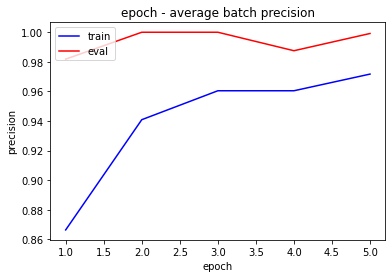

In [41]:
X_train = []
Y_train = []

for epoch, batches_precision in results_train_dict.items():
    Y_train.append(np.mean(batches_precision))
    X_train.append(epoch)

X_eval = []
Y_eval = []
for epoch, batches_precision in results_eval_dict.items():
    Y_eval.append(np.mean(batches_precision))
    X_eval.append(epoch)


#scatter plot
plt.plot(X_train, Y_train, 'b', label="train")
plt.plot(X_eval, Y_eval, 'r', label="eval")

#add title
plt.title('epoch - average batch precision')

#add x and y labels
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc="upper left")

#show plot
plt.show()

We can see that **average accuracy** increases which is really good. Now we can start doing some recommendation. Let's find `Users` who reviewed positively one `Item` and users who reviewed positively multiple `Items`. We will give our module what it believes should be a prediction score for yet unreviewed `Items`.

In [36]:
results = memgraph.execute_and_fetch(
    """
        MATCH (n:User)
        WITH n
        LIMIT 1
        MATCH (m:Item)
        OPTIONAL MATCH (n)-[r]->(m)
        WHERE r is null
        CALL tgn.predict_link_score(n,m) YIELD prediction
        WITH n,m, prediction
        WHERE prediction>0.7
        MERGE (n)-[:PREDICTED_REVIEW {likelihood:prediction}]->(m);
    """
)
for result in results:
    print(result)

Now we can apply make following query in Memgraph Lab:
```cypher
MATCH (u:User)-[pr:PREDICTED_REVIEW]->(i:Item), (u)-[r:REVIEWED]->(oi:Item)
RETURN *;
```

And after applying style, we get visualized our predicted edges:
```

@NodeStyle {
  size: 6
  color: #DD2222
  color-hover: Lighter(#DD2222)
  color-selected: Lighter(#DD2222)
  border-width: 0.6
  border-color: #1d1d1d
  font-size: 3
}

@NodeStyle HasLabel?(node, "User") {
  color: #DD2222
  color-hover: Lighter(#DD2222)
  color-selected: Lighter(#DD2222)
}

@NodeStyle HasLabel?(node, "Item") {
  color: #FB6E00
  color-hover: Lighter(#FB6E00)
  color-selected: Lighter(#FB6E00)
}

@NodeStyle Greater?(Size(Labels(node)), 0) {
  label: Format(":{}", Join(Labels(node), " :"))
}

@NodeStyle HasProperty?(node, "name") {
  label: AsText(Property(node, "name"))
}

@EdgeStyle {
  color: #999999
  color-hover: #1d1d1d
  color-selected: #1d1d1d
  width: 0.3
  width-hover: 0.9
  width-selected: 0.9
  font-size: 3
}

@EdgeStyle HasProperty?(edge, "likelihood"){
  color: #0000ff
  color-hover: #0000ff
  color-selected: #0000ff
  width: Property(edge, "likelihood")
  width-hover: 0.9
  width-selected: 0.9
  font-size: 3
}

```